In [87]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
%matplotlib inline
from segmentation_models_pytorch import utils as smpu
import seaborn as sns
from typing import List, Dict, Tuple, Union

## Конфигурация путей к данным

In [88]:
DATA_DIR = 'dataset/tiff'
PATHS = {
    'train': ('train', 'train_labels'),
    'val': ('val', 'val_labels'),
    'test': ('test', 'test_labels')
}


In [89]:
def setup_data_paths(base_dir: str, path_config: Dict[str, Tuple[str, str]]):
    """
    Создает пути к директориям с изображениями и масками.
    
    Args:
        base_dir: Базовая директория с данными
        path_config: Конфигурация поддиректорий в формате {тип: (дир_изображений, дир_масок)}
    
    Returns:
        Словарь с полными путями в формате {тип: (путь_к_изображениям, путь_к_маскам)}
    """
    return {
        data_type: (
            os.path.join(base_dir, img_dir),
            os.path.join(base_dir, mask_dir)
        ) for data_type, (img_dir, mask_dir) in path_config.items()
    }

# Создаем пути
data_paths = setup_data_paths(DATA_DIR, PATHS)
x_train_dir, y_train_dir = data_paths['train']
x_val_dir, y_val_dir = data_paths['val']
x_test_dir, y_test_dir = data_paths['test']

In [90]:
def load_class_info(csv_path: str, selected_classes: List[str]):
    """
    Загружает информацию о классах из CSV файла.
    
    Args:
        csv_path: Путь к CSV файлу с описанием классов
        selected_classes: Список классов для использования
    
    Returns:
        Кортеж (RGB значения выбранных классов, имена выбранных классов)
    """
    class_df = pd.read_csv(csv_path)
    
    # Проверка наличия необходимых колонок
    required_columns = ['name', 'r', 'g', 'b']
    if not all(col in class_df.columns for col in required_columns):
        raise ValueError(f"CSV файл должен содержать колонки: {required_columns}")
    
    # Приводим имена классов к нижнему регистру для сравнения
    class_names = class_df['name'].str.lower().tolist()
    class_rgb_values = class_df[['r', 'g', 'b']].values.tolist()
    
    # Проверка наличия запрошенных классов
    missing_classes = [cls for cls in selected_classes if cls.lower() not in class_names]
    if missing_classes:
        raise ValueError(f"Классы не найдены в CSV: {missing_classes}")
    
    # Получаем индексы выбранных классов
    selected_indices = [class_names.index(cls.lower()) for cls in selected_classes]
    
    return np.array(class_rgb_values)[selected_indices], selected_classes

# Загружаем информацию о классах
CLASS_CSV_PATH = "./dataset/label_class_dict.csv"
SELECT_CLASSES = ['background', 'road']

try:
    select_class_rgb_values, select_classes = load_class_info(CLASS_CSV_PATH, SELECT_CLASSES)
    print(f"Успешно загружены классы: {select_classes}")
    print(f"RGB значения: {select_class_rgb_values.tolist()}")
except Exception as e:
    print(f"Ошибка при загрузке информации о классах: {str(e)}")
    raise

Успешно загружены классы: ['background', 'road']
RGB значения: [[0, 0, 0], [255, 255, 255]]


## Функция для визуализации изображений

In [91]:
def visualize(**images):
    """
    Визуализирует несколько изображений в одном окне.
    
    Args:
        **images: пары имя=изображение для отображения (например, original_image=img)
    
    Example:
        visualize(
            original_image=img1,
            ground_truth=img2,
            prediction=img3
        )
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

## one-hot кодирование

In [92]:
def one_hot_encode(label: np.ndarray, 
                  label_values: List[Union[List[int], np.ndarray]]):
    """
    Конвертирует RGB маску в one-hot encoded маску.
    
    Args:
        label: RGB маска формы (H, W, 3)
        label_values: Список RGB значений классов
    
    Returns:
        One-hot encoded маска формы (H, W, num_classes)
    """   
    semantic_map = []
    for colour in label_values:
        # Сравниваем каждый пиксель с целевым цветом класса
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)  # Логическое И по каналам
        semantic_map.append(class_map)
    
    return np.stack(semantic_map, axis=-1).astype(np.float32)

def reverse_one_hot(image: np.ndarray):
    """
    Конвертирует one-hot encoded маску обратно в классовые индексы.
    
    Args:
        image: One-hot encoded маска формы (H, W, num_classes)
    
    Returns:
        Маска с классовыми индексами формы (H, W)
    """
    return np.argmax(image, axis=-1)

def colour_code_segmentation(image: np.ndarray, 
                           label_values: List[Union[List[int], np.ndarray]]):
    """
    Кодирует маску с классовыми индексами в RGB маску.
    
    Args:
        image: Маска с классовыми индексами формы (H, W)
        label_values: Список RGB значений классов
    
    Returns:
        RGB маска формы (H, W, 3)
    """
    colour_codes = np.array(label_values)
    return colour_codes[image.astype(np.uint8)]

## Аугментации

In [93]:
def get_training_augmentation():
    """
    Создаёт пайплайн аугментации для обучающего набора данных.
    
    Аугментации включают:
    - Случайное обрезание изображения до 256x256.
    - Одну из следующих трансформаций (с вероятностью 0.75):
        * Горизонтальное отражение,
        * Вертикальное отражение,
        * Случайный поворот на 90 градусов.
    
    Returns:
        Albumentations Compose объект с трансформациями.
    """
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([
            album.HorizontalFlip(p=1),
            album.VerticalFlip(p=1),
            album.RandomRotate90(p=1)
        ], p=0.75)
    ]
    
    return album.Compose(train_transform)


def get_validation_augmentation():
    """
    Создаёт пайплайн аугментации для валидационного/тестового набора данных.
    
    Применяет дополнение изображения до минимального размера 1536x1536.
    
    Returns:
        Albumentations Compose объект с трансформацией.
    """
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)
    ]
    
    return album.Compose(test_transform)


def to_tensor(x: np.ndarray, **kwargs):
    """
    Преобразует изображение из HWC в CHW формат и тип float32.
    
    Args:
        x: Изображение в формате (H, W, C)
    
    Returns:
        Изображение в формате (C, H, W), тип float32
    """
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """
    Создаёт пайплайн препроцессинга данных.
    
    Если указана функция препроцессинга, она применяется к изображению.
    Затем изображение и маска преобразуются в формат CHW и float32.
    
    Args:
        preprocessing_fn: Функция препроцессинга (например, нормализация)
    
    Returns:
        Albumentations Compose объект с трансформациями.
    """
    _transform = []

    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)


## Визуализация метрик обучения

In [94]:
sns.set_style("whitegrid")
plt.style.use('ggplot')


def plot_training_metrics(train_logs_list, val_logs_list, save_path=None):
    """
    Визуализирует метрики обучения (Dice Loss и IoU Score) для тренировочного и валидационного наборов.
    
    Аргументы:
        train_logs_list (list[dict]): Список словарей с метриками на обучающем наборе.
        val_logs_list (list[dict]): Список словарей с метриками на валидационном наборе.
        save_path (str, optional): Путь для сохранения графика. Если None — график отобразится.
    """
    # Извлечение метрик
    train_loss = [epoch['dice_loss'] for epoch in train_logs_list]
    val_loss = [epoch['dice_loss'] for epoch in val_logs_list]
    
    train_iou = [epoch['iou_score'] for epoch in train_logs_list]
    val_iou = [epoch['iou_score'] for epoch in val_logs_list]
    
    epochs = list(range(1, len(train_logs_list) + 1))

    # Создание графиков
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # --- Dice Loss ---
    axes[0].plot(epochs, train_loss, label='Train Loss', marker='o')
    axes[0].plot(epochs, val_loss, label='Validation Loss', marker='x')
    axes[0].set_title('Dice Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # --- IoU Score ---
    axes[1].plot(epochs, train_iou, label='Train IoU', marker='o')
    axes[1].plot(epochs, val_iou, label='Validation IoU', marker='x')
    axes[1].set_title('IoU Score per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].legend()

    plt.show()

In [95]:
class RoadsDataset(torch.utils.data.Dataset):
	"""
	Кастомный датасет для сегментации дорог. Загружает изображения и соответствующие маски,
	выполняет one-hot кодирование масок и применяет аугментации и препроцессинг, если указаны.

	Аргументы:
		images_dir (str): Путь к директории с изображениями.
		masks_dir (str): Путь к директории с масками.
		class_rgb_values (list[tuple]): Список RGB-значений классов для one-hot кодирования.
		augmentation (albumentations.Compose, optional): Аугментации, применяемые к изображениям и маскам.
		preprocessing (albumentations.Compose, optional): Препроцессинг.
	"""

	def __init__(self, images_dir, masks_dir, class_rgb_values=None,
				augmentation=None, preprocessing=None):
		self.image_paths = [os.path.join(images_dir, image_id)
							for image_id in sorted(os.listdir(images_dir))]
		self.mask_paths = [os.path.join(masks_dir, image_id)
							for image_id in sorted(os.listdir(masks_dir))]
		self.class_rgb_values = class_rgb_values
		self.augmentation = augmentation
		self.preprocessing = preprocessing

	def __getitem__(self, i):
		# Чтение изображения и маски, приведение к RGB
		image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
		mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

		# One-hot кодирование маски
		mask = one_hot_encode(mask, self.class_rgb_values).astype('float32')

		# Аугментации
		if self.augmentation:
			sample = self.augmentation(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']

		# Препроцессинг
		if self.preprocessing:
			sample = self.preprocessing(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']

		return image, mask

	def __len__(self):
		return len(self.image_paths)

## Инициализация UNET

In [96]:
# Параметры модели
ENCODER = 'resnet50'                 # Энкодер: ResNet-50
ENCODER_WEIGHTS = 'imagenet'         # Предобученные веса на ImageNet
CLASSES = select_classes             # Список целевых классов сегментации
ACTIVATION = 'sigmoid'               # Активация на выходе

# Инициализация модели UNet
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Функция препроцессинга изображений под выбранный энкодер
preprocessing_fn = smp.encoders.get_preprocessing_fn(
    encoder_name=ENCODER,
    pretrained=ENCODER_WEIGHTS
)

## Загрузка данных

In [97]:
# Создание тренировочного датасета с аугментацией и препроцессингом
train_dataset = RoadsDataset(
    images_dir=x_train_dir,
    masks_dir=y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Создание валидационного датасета с препроцессингом и минимальной аугментацией
val_dataset = RoadsDataset(
    images_dir=x_val_dir,
    masks_dir=y_val_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Загрузчики данных
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

/tmp/ipykernel_1053150/2309997180.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  album.RandomCrop(height=256, width=256, always_apply=True),
/tmp/ipykernel_1053150/2309997180.py:37: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)


## Подготовка к обучению

In [98]:
# Конфигурация
TRAINING = True
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {DEVICE}")

# Функция потерь и метрики
loss = smpu.losses.DiceLoss()  # Dice loss — хорошо подходит для задач сегментации
metrics = [smpu.metrics.IoU(threshold=0.5)]  # IoU (Intersection over Union)

# Оптимизатор
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=8e-5
)

# Плавное косинусное уменьшение learning rate с рестартами
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=1,
    T_mult=2,
    eta_min=5e-5
)

Используемое устройство: cuda


## Обучение

In [99]:
train_epoch = smp.utils.train.TrainEpoch(model, loss=loss, metrics=metrics,
                                         optimizer=optimizer, device=DEVICE,
                                         verbose=True)

val_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics,
                                         device=DEVICE, verbose=True)


Epoch: 1
valid: 100%|██████████| 14/14 [00:01<00:00,  7.50it/s, dice_loss - 0.3097, iou_score - 0.7955]
Model saved

Epoch: 2
valid: 100%|██████████| 14/14 [00:01<00:00,  7.54it/s, dice_loss - 0.2594, iou_score - 0.8438]
Model saved

Epoch: 3
valid: 100%|██████████| 14/14 [00:01<00:00,  7.51it/s, dice_loss - 0.2241, iou_score - 0.8462]
Model saved

Epoch: 4
valid: 100%|██████████| 14/14 [00:01<00:00,  7.47it/s, dice_loss - 0.1876, iou_score - 0.8576]
Model saved

Epoch: 5
valid: 100%|██████████| 14/14 [00:01<00:00,  7.50it/s, dice_loss - 0.1586, iou_score - 0.8684]
Model saved


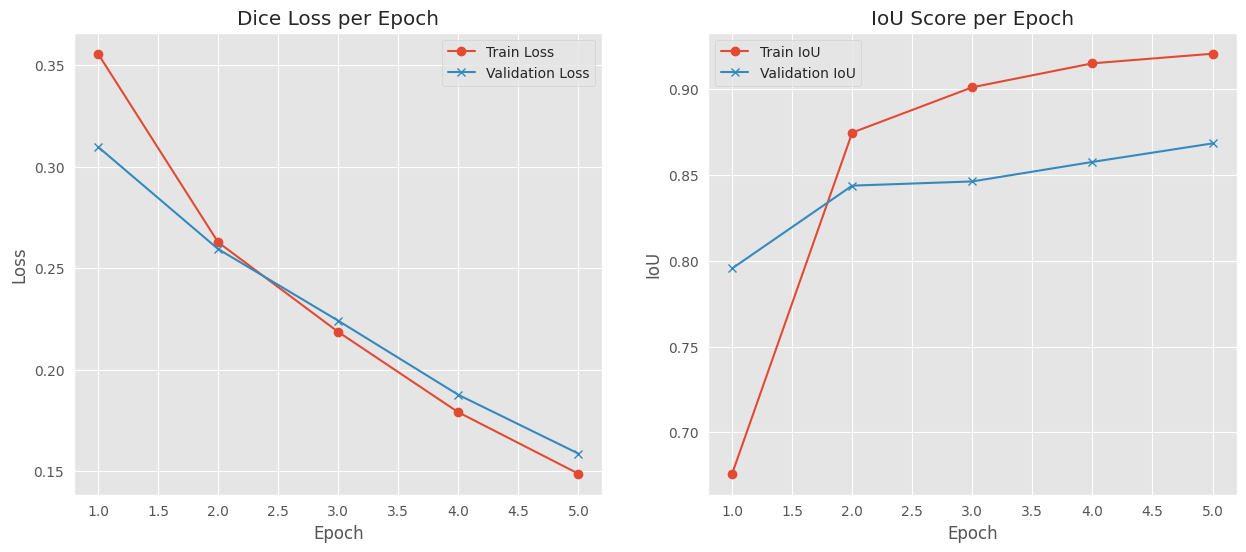

In [100]:
if TRAINING:
    best_iou_score = 0.0  # Изначально лучший IoU равен 0
    train_logs_list, val_logs_list = [], []  # Списки для хранения логов по каждой эпохе

    # Цикл по эпохам
    for epoch in range(EPOCHS):
        print(f'\nEpoch: {epoch + 1}')
        
        # Шаг обучения
        train_logs = train_epoch.run(train_loader)
        
        # Шаг валидации
        val_logs = val_epoch.run(val_loader)
        
        # Добавляем логи текущей эпохи в списки
        train_logs_list.append(train_logs)
        val_logs_list.append(val_logs)
        
        # Сохранение модели с лучшим IoU
        if best_iou_score < val_logs['iou_score']:
            best_iou_score = val_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved')

    # Визуализация метрик после всех эпох
    plot_training_metrics(train_logs_list, val_logs_list, save_path='./metrics_plots')

## Тестирование и визуализация

In [101]:
# Создание тестового датасета и загрузчика данных
test_dataset = RoadsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Создание датасета для визуализации
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# Функция для обрезки изображения (если оно больше целевого размера)
def crop_image(image, target_image_dims=[1500,1500,3]):
    """
    Обрезает изображение, если оно больше целевого размера, чтобы оно соответствовало
    целевым размерам. Если изображение меньше, возвращает его как есть.
    """
    target_size = target_image_dims[0]
    image_size = image.shape[0]
    padding = (image_size - target_size) // 2

    if padding < 0:
        return image  # Если изображение меньше целевого размера, возвращаем его без изменений

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :
    ]

# Папка для предсказаний
preds_folder = 'predictions/'
if not os.path.exists(preds_folder):
    os.makedirs(preds_folder)


/tmp/ipykernel_1053150/2309997180.py:37: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)


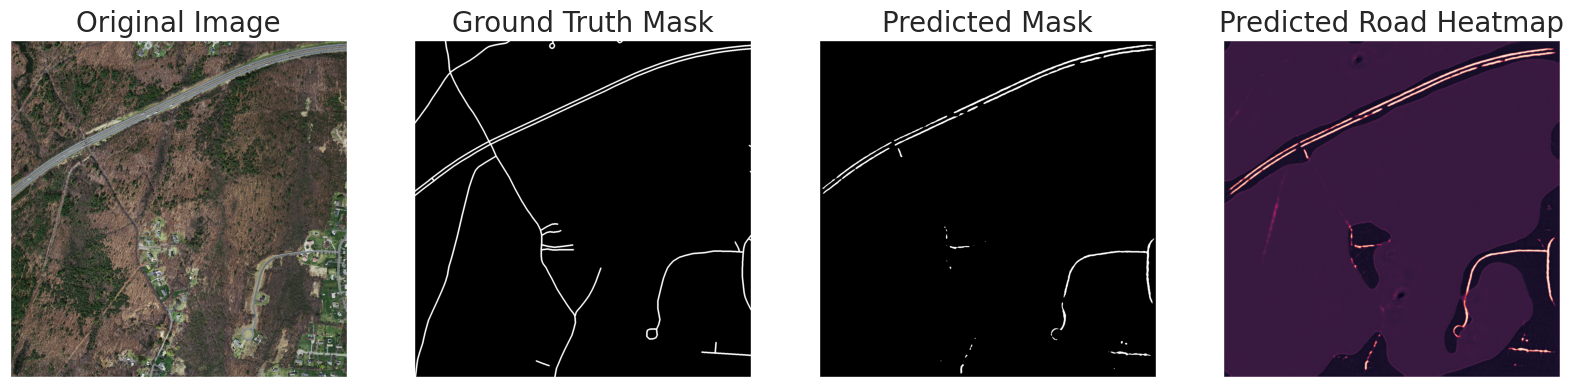

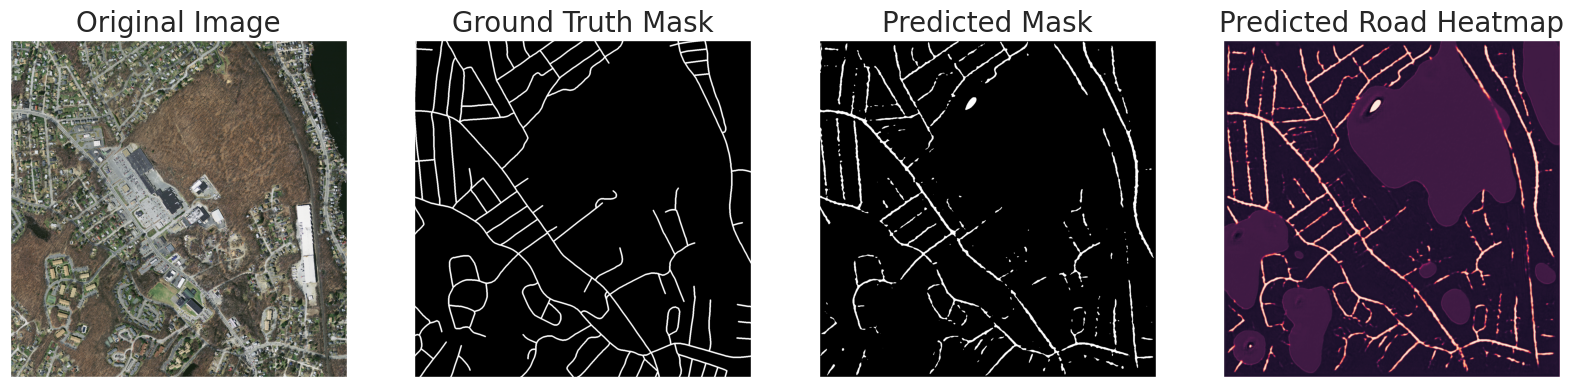

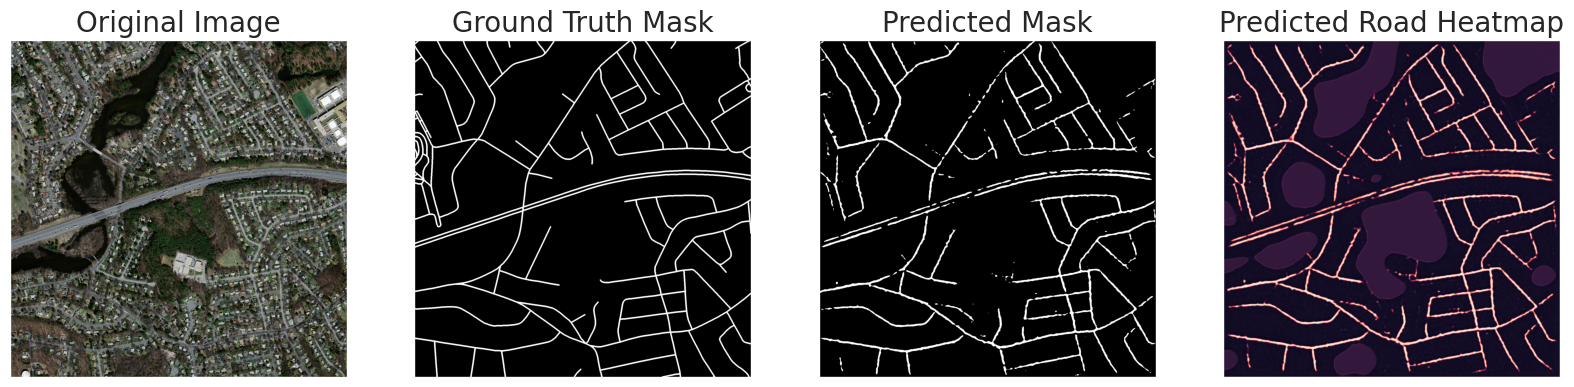

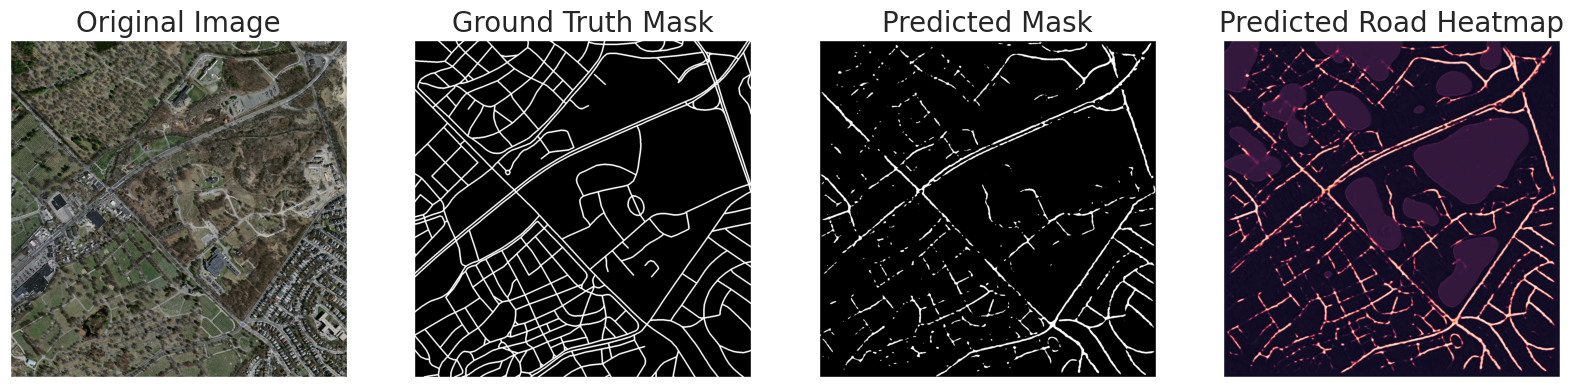

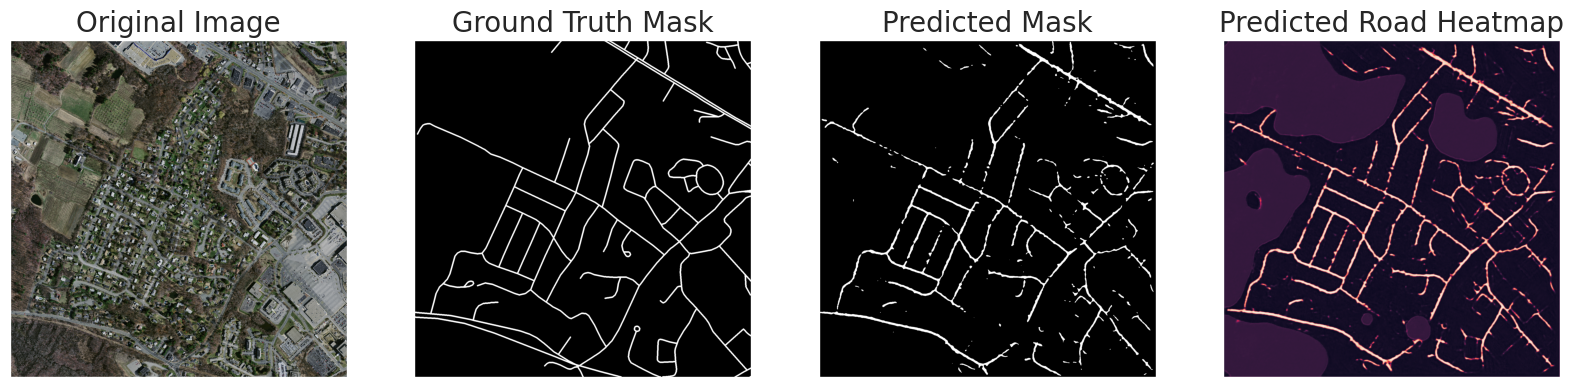

In [102]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))  # Обрезаем изображение для визуализации

    # Преобразование изображения в тензор
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0).float()

    # Предсказание маски для тестового изображения
    with torch.no_grad():  # Отключаем градиенты для предсказаний
        pred_mask = model(x_tensor)

    if idx % 10 == 0:
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()

        # Преобразование предсказания из CHW в HWC
        pred_mask = np.transpose(pred_mask, (1, 2, 0))

        # Получаем тепловую карту для дороги (по индексу из списка классов)
        pred_road_heatmap = pred_mask[:, :, select_classes.index('road')]

        # Преобразуем маску предсказания в цветное изображение
        pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))

        # Преобразуем gt_mask в HWC и применяем цветовую кодировку
        gt_mask = np.transpose(gt_mask, (1, 2, 0))
        gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))

        # Сохраняем результат в файл
        cv2.imwrite(os.path.join(preds_folder, f"sample_pred_{idx}.png"), 
                    np.hstack([image_vis, gt_mask, pred_mask])[:, :, ::-1])  # Преобразуем в BGR для OpenCV

        # Визуализация результатов
        visualize(
            original_image=image_vis,
            ground_truth_mask=gt_mask,
            predicted_mask=pred_mask,
            predicted_road_heatmap=pred_road_heatmap
        )
